# Data exploration of Grocery Prices in Jamaica

Source: https://www.data.gov.jm/dataset/consumer-grocery-prices

Timespan about 2012-2017

## Setup imports

In [1]:
%matplotlib inline

import os, sys
import shutil
import tempfile
import glob
import re
import time
import datetime
import copy
import pickle
import hashlib
import logging
import warnings
import random

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_style("whitegrid")
pd.set_option('display.max_rows', 100)

In [2]:
# log level
logging.basicConfig(
    stream=sys.stdout,
    format='%(asctime)s %(levelname)s: %(message)s',
    level=logging.INFO)

logger = logging.getLogger("notebook")
logger.setLevel(logging.DEBUG)

# disable font not found warnings
logging.getLogger('matplotlib.font_manager').disabled = True

## Read data

In [3]:
# Use Jupyter magic to retain variable in this notebook
%env DATA_DIRECTORY=data

data_dir = os.environ.get("DATA_DIRECTORY")
#root_dir = tempfile.mkdtemp() if directory is None else directory
dataset_regex = "Grocery_Price_Survey_201?_Q?.csv"

env: DATA_DIRECTORY=data


In [4]:
from pathlib import Path

csv_files = list(Path(data_dir).glob(dataset_regex))
len(csv_files)

21

In [5]:
df_list = []

for f in csv_files:
    df_list.append(pd.read_csv(f, parse_dates=['SurveyDate'],
                               dtype={'Outlet_Name': 'str', 'Town': 'str',
                                      'Parish': 'str', 'Item':'str', 'Price': np.float64},
                               na_values=['N\\A']))

df = pd.concat(df_list, ignore_index=True, axis=0)

In [6]:
df.dtypes

OutletID                int64
SurveyDate     datetime64[ns]
Outlet_Name            object
Town                   object
Parish                 object
Item                   object
ItemID                  int64
Price                 float64
dtype: object

In [7]:
df.Price.isnull().sum()

np.int64(97746)

In [8]:
df.shape

(606454, 8)

In [9]:
# Drop null prices
df = df.dropna()
# Drop non positive prices
df = df[df.Price > 0.]
df.shape

(369563, 8)

In [10]:
def clean_names(column):
    """
    Strip backslashes and leading and trailing spaces
    """
    # dump multiple spaces
    temp = column.str.replace("\\","")
    temp = temp.str.replace("  "," ")
    temp = temp.str.replace("   "," ")
    temp = temp.str.strip(' -')
    temp = temp.str.title()
    temp = temp.str.replace("'S", "'s")
    temp = temp.str.replace("St.Thomas", "St. Thomas") 

    return temp

In [11]:
for name in df.columns[[2,3,4,5]]:
    df[name] = clean_names(df[name])

In [12]:
df.sort_values('SurveyDate')

,OutletID,SurveyDate,Outlet_Name,Town,Parish,Item,ItemID,Price
517899,154,2012-01-05,Super Plus,Four Paths,Clarendon,Sweetened Condensed Milk [Tx] Nestle 395 G,9149452,150.00
520231,89,2012-01-05,Joong,Portmore,St. Catherine,Powdered Laundry Detergent [Tx] Ariel 400 G,7843653,163.99
520232,89,2012-01-05,Joong,Portmore,St. Catherine,Insect Spray [Tx] Baygon 260 Ml,6443742,274.00
520233,89,2012-01-05,Joong,Portmore,St. Catherine,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,368.00
520234,89,2012-01-05,Joong,Portmore,St. Catherine,Pepper [Tx] Betapac 110 G,7643928,191.00
...,...,...,...,...,...,...,...,...
101898,192,2017-03-09,Zhen's Wholesale,Cambridge,St. James,Matches [Tx] Any 1 Pk,7281823,50.00
101896,192,2017-03-09,Zhen's Wholesale,Cambridge,St. James,Mosquito Destroyer [Tx] Vape 6 Coils,7381961,80.00
101895,192,2017-03-09,Zhen's Wholesale,Cambridge,St. James,Mosquito Destroyer [Tx] Bug Off 6 Coils,7344661,65.00
101904,192,2017-03-09,Zhen's Wholesale,Cambridge,St. James,Laundry Soap Bar [Tx] Bomber 140 G,6644181,55.00


In [13]:
df.columns

Index(['OutletID', 'SurveyDate', 'Outlet_Name', 'Town', 'Parish', 'Item',
       'ItemID', 'Price'],
      dtype='object')

In [14]:
# OutletID mapping to Outlet_Name
for c in df.columns[[0,2]]:
    print(c, len(df[c].unique()))

OutletID 135
Outlet_Name 113


In [15]:
# ItemID mapping to Item
for c in df.columns[[6,5]]:
    print(c, len(df[c].unique()))

ItemID 231
Item 231


Looks like Item mapping is one-to-one, but Outlet_Name is one-to-many. This is probably due to different location so no action needed.

In [16]:
supermarkets = sorted(df.Outlet_Name.unique())

In [17]:
# TBD clean-up with Sashara

supermarkets

["A J's Supermarket",
 "Abc Supermarket - Brown's Town",
 'Ambersley',
 'Any Money Supermarket',
 "Auntie Maur's Supermarket",
 'Basic Needs Supermarket',
 'Bay City Supermarket- Montego Bay',
 'Best Buy Mini Mart',
 'Best Value Supermarket',
 'Best Way Wholesale',
 'Better & Better Supermarket- Annotto Bay',
 'Brooklyn (Clock Tower Plaza)',
 'Brooklyn (Twin Gates Plaza)',
 "Brown's Town Supermarket",
 'Bull Head Supermarket',
 "Campbell's Supermarket",
 'Cari Home Supermarket',
 'Century Supermarket',
 'Cheries Supermarket',
 'Cherish Supermaket',
 'Classic Super Shop',
 "Consumers' Meat Plus",
 'D & Y Supermarket',
 'Daily Foods Supermarket',
 "Dotty's Grocery",
 'Empire Supermarket (Portmore Pines)',
 'Empire Supermarket- Cross Roads',
 'Empire Supermarket-Liguanea',
 'Exquisite Grocery',
 'Family Choice',
 'Family Pride',
 'Fedlin Supermarket',
 "Floyd's Supermarket",
 'Food Palace Wholesale',
 'Friendship Grocery',
 "Gayle's Grocery",
 'General Food Supermarket',
 "Graham's",
 'Gr

In [18]:
# TODO check with Sashara
towns = sorted(df.Town.unique())
len(towns)

55

In [19]:
# TODO Kingston is missing here...
parishes = sorted(df.Parish.unique())
len(parishes)

13

In [20]:
df.head()

,OutletID,SurveyDate,Outlet_Name,Town,Parish,Item,ItemID,Price
1,243,2015-07-09,Shopper's Pride,Buff Bay,Portland,Batteries [Tx] Panasonic C,11649990,260.0
2,243,2015-07-09,Shopper's Pride,Buff Bay,Portland,Cabbage (Green) [Nt] Local 1 Kg,3548621,170.0
3,243,2015-07-09,Shopper's Pride,Buff Bay,Portland,Batteries [Tx] Duracell Aa,11646291,250.0
5,243,2015-07-09,Shopper's Pride,Buff Bay,Portland,Water Crackers National 143 G,5049392,71.0
7,243,2015-07-09,Shopper's Pride,Buff Bay,Portland,Dark Sugar (Pre-Packaged) [Nt] Sunshine Crysta...,11751122,171.0


In [21]:
# TODO what nt and tx means?? strip these?

items = sorted(df.Item.unique())
len(items)

231

<Axes: xlabel='Price', ylabel='Count'>

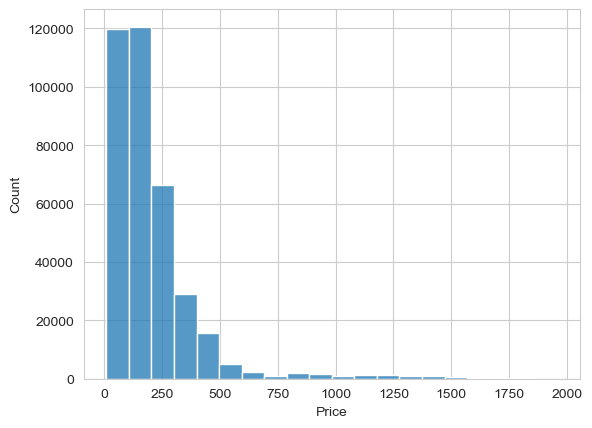

In [26]:
sns.histplot(df.Price, bins=20)

In [28]:
df[df.ItemID == 10243821].sort_values('Price')

,OutletID,SurveyDate,Outlet_Name,Town,Parish,Item,ItemID,Price
543813,188,2012-02-09,Parkview Supermarket,Papine,St. Andrew,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,41.10
451891,568,2012-08-23,Salmon Supermarket,Falmouth,Trelawny,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,166.78
545458,73,2012-02-23,Hi-Lo Supermarket,Mandeville,Manchester,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,241.03
561437,559,2012-03-22,Mitchie Super Save Grocery - Sandy Bay,Sandy Bay,Clarendon,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,286.00
512936,570,2012-06-21,Price Break Meats & Grocery - Brown's Town,Brown's Town,St. Ann,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,303.60
...,...,...,...,...,...,...,...,...
353141,84,2016-07-07,Intown Supersave,Junction,St. Elizabeth,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,564.52
347225,84,2016-06-09,Intown Supersave,Junction,St. Elizabeth,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,566.72
34534,180,2015-05-07,Cari Home Supermarket,Constant Spring,St. Andrew,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,573.39
379937,72,2014-10-09,Hi-Lo Basix,Montego Bay,St. James,"Whole Chicken (Grade A, Frozen) [Nt] Best Dres...",10243821,581.40


In [ ]:
# save pickle, make save point

## Parse data dump

In [21]:
# 2024 training data
training = df.loc[(df.start_date > '2024-01-01') & (df.start_date_local < '2024-04-30')]

In [22]:
# DJBB 2024
race = df.loc[df.name.str.contains('DJBB')]

In [23]:
training.head()

,resource_state,name,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,workout_type,id,...,pr_count,total_photo_count,has_kudoed,suffer_score,athlete.id,athlete.resource_state,map.id,map.summary_polyline,map.resource_state,average_temp
8,2,Morning Ride,4780.4,987,1914,61.0,Ride,Ride,NaN,11291134982,...,0,0,False,NaN,104560661,1,a11291134982,ehcmBr~ssMv@X|@b@~CbA`@TFNCHqAhC[|@uBvE]`@a@Zm...,2,32.0
9,2,Morning Ride,49279.1,10733,17090,800.0,Ride,Ride,10.0,11284528671,...,19,1,False,61.0,104560661,1,a11284528671,ghcmBx~ssMbIlCjFeAC\xc@|RlEpDjO|TxBkAxFYhFqC`P...,2,26.0
10,2,Morning Ride,30850.8,6768,8325,694.0,Ride,Ride,10.0,11267859653,...,14,4,False,59.0,104560661,1,a11267859653,oycmBprrsM|@gAv@{C~@o@zAM|@JvGrDtBb@zO?tD~AvCV...,2,23.0
11,2,Lunch Swim,475.0,1807,1807,0.0,Swim,Swim,NaN,11262576995,...,0,2,False,12.0,104560661,1,a11262576995,NaN,2,NaN
12,2,Lunch Ride,6438.6,1353,8077,103.0,Ride,Ride,12.0,11263227838,...,0,0,False,NaN,104560661,1,a11263227838,ihcmBz~ssM~Al@hBj@bA^PJRD\AhAc@^ILIDQB]FmABKBE...,2,38.0


## Training statistics

In [24]:
from dateutil import relativedelta
 
def convert_seconds(n):
    rd = relativedelta.relativedelta(seconds=n)
    return "{}h {:02d}m".format(rd.days*24+rd.hours, rd.minutes)

In [25]:
# total training moving time
convert_seconds(training.moving_time.sum())

'113h 11m'

In [26]:
# for each sport
sport_types = list(training.type.unique())

for s in sport_types:
    total = training.loc[training.type == s].moving_time.sum()
    pretty_time = convert_seconds(total)
    print("{}: {}".format(s,pretty_time))

Ride: 60h 35m
Swim: 4h 13m
Walk: 11h 26m
Run: 4h 58m
Workout: 8h 27m
VirtualRide: 19h 13m
WeightTraining: 4h 16m


In [28]:
# for each sport
sport_types = list(training.type.unique())
totals_hr = []

for s in sport_types:
    total_s = training.loc[training.type == s].moving_time.sum()
    totals_hr.append(total_s / 3600)

totals_df = pd.DataFrame(data=totals_hr, index=sport_types, columns=['total moving time (h)'])

/tmp/ipykernel_110/3815723056.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


Text(0.5, 1.0, 'DJBB 2024 training')

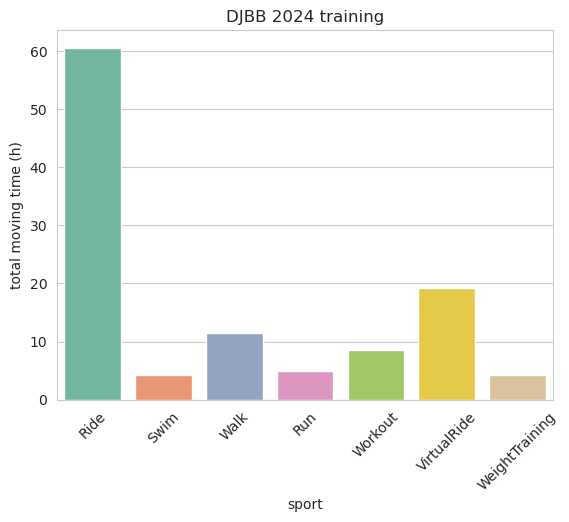

In [50]:
ax = sns.barplot(
    x=totals_df.index,
    y=totals_df['total moving time (h)'],
    palette=sns.color_palette("Set2", 7),
)
ax.tick_params(axis='x', rotation=45)
ax.set(xlabel='sport')
ax.set_title("DJBB 2024 training")

In [189]:
# riding hours and kilometers
ride_df =  training.loc[training.type == 'Ride']

total_km = ride_df.distance.sum() / 1000
active_wks = (17-8-2+1)
km_per_wk = total_km / active_wks

total_elevation_gain = ride_df.total_elevation_gain.sum()

print("Active riding weeks:", active_wks)
print("Average rides per week: {:.1f}".format(ride_df.shape[0]/active_wks))
print("Average km per week: {:.1f}".format(km_per_wk))
print("Total km: {:.1f}".format(total_km))
print("Total elevation gain (m): {:.0f}\n".format(total_elevation_gain))

Active riding weeks: 8
Average rides per week: 4.0
Average km per week: 166.1
Total km: 1328.9
Total elevation gain (m): 12106



In [182]:
# temperatures
ride_df.average_temp.describe()

count    32.000000
mean     26.687500
std       5.396758
min      19.000000
25%      23.000000
50%      25.500000
75%      30.250000
max      39.000000
Name: average_temp, dtype: float64

## DJBB2024 statistics

In [159]:
# total moving time
convert_seconds(race.moving_time.sum())

'26h 10m'

In [160]:
total_dist_km = race.distance.sum()/1000
print("Total distance: {:.1f} ({:.1f}miles)".format(total_dist_km, total_dist_km/1.6))

Total distance: 627.4 (392.1miles)


In [161]:
avg_spd_km = total_dist_km / (race.moving_time.sum()/3600)
print("Average speed: {:.1f}km ({:.1f}mph)".format(avg_spd_km, avg_spd_km/1.6))

Average speed: 24.0km (15.0mph)


In [196]:
total_elevation_gain_m = race.total_elevation_gain.sum()
print("Total elevation gain: {:.1f}m ({:.1f}feet)".format(
    total_elevation_gain_m,
    total_elevation_gain_m/.3048))

Total elevation gain: 5983.0m (19629.3feet)


In [183]:
# temperatures
race.average_temp.describe()

count     5.00000
mean     30.60000
std       1.67332
min      28.00000
25%      30.00000
50%      31.00000
75%      32.00000
max      32.00000
Name: average_temp, dtype: float64